<a href="https://colab.research.google.com/github/CryptoRobotFr/General-code-trading-bot/blob/main/VuManchuCipherB_Indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install python-binance ta

<h1> Récupération des données à partir de Binance <h1>

In [17]:
# Importation des librairies
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Variables pour les données
client = Client()
pair_symbol = "ETHUSDT"
time_interval = Client.KLINE_INTERVAL_1HOUR
start_date = "01 january 2021"

# Récupération des données
klinesT = client.get_historical_klines(pair_symbol, time_interval, start_date)

# Créer un tableau grâce aux données
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])

# Supprime les colonnes inutiles
df.drop(columns = df.columns.difference(['timestamp','open','high','low','close','volume']), inplace=True)

# Convertit les colonnes en numéric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Convertit les dates dans un format lisible
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

# Affiche le tableau
df

,open,high,low,close,volume
timestamp,,,,,
2021-01-01 00:00:00,736.42,739.00,729.33,734.07,27932.69884
2021-01-01 01:00:00,734.08,749.00,733.37,748.28,52336.18779
2021-01-01 02:00:00,748.27,749.00,742.27,744.06,33019.50100
2021-01-01 03:00:00,744.06,747.23,743.10,744.82,17604.80859
2021-01-01 04:00:00,744.87,747.09,739.30,742.29,18794.15424
...,...,...,...,...,...
2022-04-15 06:00:00,3038.77,3042.80,3019.13,3023.17,8383.74300
2022-04-15 07:00:00,3023.18,3046.41,3010.85,3034.62,15958.94770
2022-04-15 08:00:00,3034.62,3040.54,3017.08,3025.00,11739.49650


<h1> Définition des indicateurs <h1>

In [18]:
#Partie VMC


#df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True) 

class VMC():
    """ VuManChu Cipher B + Divergences 
        Args:
            high(pandas.Series): dataset 'High' column.
            low(pandas.Series): dataset 'Low' column.
            close(pandas.Series): dataset 'Close' column.
            wtChannelLen(int): n period.
            wtAverageLen(int): n period.
            wtMALen(int): n period.
            rsiMFIperiod(int): n period.
            rsiMFIMultiplier(int): n period.
            rsiMFIPosY(int): n period.
    """
    def __init__(
        self: pd.Series,
        high: pd.Series,
        low: pd.Series,
        close: pd.Series,
        open: pd.Series,
        wtChannelLen: int = 9,
        wtAverageLen: int = 12,
        wtMALen: int = 3,
        rsiMFIperiod: int = 60,
        rsiMFIMultiplier: int = 150,
        rsiMFIPosY: int = 2.5
    ) -> None:
        self._high = high
        self._low = low
        self._close = close
        self._open = open
        self._wtChannelLen = wtChannelLen
        self._wtAverageLen = wtAverageLen
        self._wtMALen = wtMALen
        self._rsiMFIperiod = rsiMFIperiod
        self._rsiMFIMultiplier = rsiMFIMultiplier
        self._rsiMFIPosY = rsiMFIPosY
        self._run()
        self.wave_1()

    def _run(self) -> None:
        try:
            self._esa = ta.trend.ema_indicator(
                close=self._close, window=self._wtChannelLen)
        except Exception as e:
            print(e)
            raise

        self._esa = ta.trend.ema_indicator(
            close=self._close, window=self._wtChannelLen)
        self._de = ta.trend.ema_indicator(
            close=abs(self._close - self._esa), window=self._wtChannelLen)
        self._rsi = ta.trend.sma_indicator(self._close, self._rsiMFIperiod)
        self._ci = (self._close - self._esa) / (0.015 * self._de)

    def wave_1(self) -> pd.Series:
        """VMC Wave 1 
        Returns:
            pandas.Series: New feature generated.
        """
        wt1 = ta.trend.ema_indicator(self._ci, self._wtAverageLen)
        return pd.Series(wt1, name="wt1")

    def wave_2(self) -> pd.Series:
        """VMC Wave 2
        Returns:
            pandas.Series: New feature generated.
        """
        wt2 = ta.trend.sma_indicator(self.wave_1(), self._wtMALen)
        return pd.Series(wt2, name="wt2")

    def money_flrow(self) -> pd.Series:
        """VMC Money Flow
            Returns:
            pandas.Series: New feature generated.
        """
        mfi = ((self._close - self._open) /
                (self._high - self._low)) * self._rsiMFIMultiplier
        rsi = ta.trend.sma_indicator(mfi, self._rsiMFIperiod)
        money_flow = rsi - self._rsiMFIPosY
        return pd.Series(money_flow, name="money_flow")



In [19]:
# Ajout de nouvelle colonne dans le tableau représentant nos indicateurs

#---------VMC-----------
df['HLC3'] = (df['high'] +df['close'] + df['low'])/3
vmc = VMC(high =df['high'],low = df['low'],close=df['HLC3'],open=df['open'])
df['VMC_WAVE1'] = vmc.wave_1()
df['VMC_WAVE2'] = vmc.wave_2()
vmc = VMC(high =df['high'],low = df['low'],close=df['close'],open=df['open'])
df['MONEY_FLOW'] = vmc.money_flow()


#---------EMA--------------
df['EMA50'] = ta.trend.ema_indicator(close = df['close'], window = 50)
df['EMA200'] = ta.trend.ema_indicator(close = df['close'], window = 200)




# Affiche notre nouveau tableau
df

,open,high,low,close,volume,HLC3,VMC_WAVE1,VMC_WAVE2,MONEY_FLOW,EMA50,EMA200
timestamp,,,,,,,,,,,
2021-01-01 00:00:00,736.42,739.00,729.33,734.07,27932.69884,734.133333,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,734.08,749.00,733.37,748.28,52336.18779,743.550000,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,748.27,749.00,742.27,744.06,33019.50100,745.110000,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00,744.06,747.23,743.10,744.82,17604.80859,745.050000,NaN,NaN,NaN,NaN,NaN
2021-01-01 04:00:00,744.87,747.09,739.30,742.29,18794.15424,742.893333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-15 06:00:00,3038.77,3042.80,3019.13,3023.17,8383.74300,3028.366667,6.553563,5.175912,0.325796,3052.146318,3138.695508
2022-04-15 07:00:00,3023.18,3046.41,3010.85,3034.62,15958.94770,3030.626667,7.483695,7.659646,3.004584,3051.459012,3137.659931
2022-04-15 08:00:00,3034.62,3040.54,3017.08,3025.00,11739.49650,3027.540000,3.467782,5.835013,0.687440,3050.421403,3136.538936


In [20]:
dfTest = df.copy()
initial_wallet = 1000 # Somme d'usd au début de la stratégie
taker_fee = 0.0007 # ~ 0.07% de frais sur binance et ftx 

sl_price = 0
tp_price = 1000000

# Initalisation de notre portefeuille
wallet = initial_wallet
usd = initial_wallet
coin = 0

# Initialisation de nos tableaux qui vont contenir nos données d'analyse
trades_hitory = []
days_history = []
previous_day = 0
buy_ready = True

previous_row = df.iloc[0].copy()
#previous_row['close'] < max(row['SSB25'],row['SSA25']) and previous_row['close'] > min(row['SSB25'],row['SSA25']) and

def buy_condition(row, previous_row=None):
    if row['EMA50'] > row ['EMA200'] and row ['close'] > row['EMA50'] and row['MONEY_FLOW'] >  0 and row['VMC_WAVE1'] < 0 and row['VMC_WAVE2'] < 0 and row['VMC_WAVE1'] > row['VMC_WAVE2'] and previous_row['VMC_WAVE1'] < previous_row['VMC_WAVE2'] :
        return True
    else:
        return False    

def sell_condition(row, previous_row=None):
    if row['close'] >10000000 :
        return True
    else:
        return False  


# Simulation de notre stratégie en parcourant notre tableau ligne par ligne
for index, row in df.iterrows():

    # Garde en mémoire l'évolution de notre portefeuille chaque jour pour pouvoir analyser plus tard
    current_day = index.day
    if previous_day != current_day:
        temp_wallet = wallet
        if coin > 0:
            temp_wallet = coin*row['close']
        days_history.append({
            "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
            "wallet":temp_wallet,
            "price":row['close']
        })
    previous_day = current_day

    # Vérifie les conditions si l'on doit acheter
    if buy_condition(row, previous_row) == True and usd > 0 and buy_ready == True:
        # Condition vérifiée, on achète à la clotûre
        coin = usd / row['close']           
        fee = taker_fee * coin             
        coin = coin - fee                   
        usd = 0                            
        wallet = coin * row['close']       
        # Ajout de données pour analyse future
        buy_data = {
            'date': index,
            'position': 'buy',
            'price': row['close'],
            'fee': fee * row['close'],
            'usd': usd,
            'coin': coin,
            'wallet': wallet,
            'reason': "market"
        }
        trades_hitory.append(buy_data)
        sl_price = row['EMA200'] # A editer si l'on souhaite ajouter un sl
        tp_price = row['close'] + 2*(row['close']-row['EMA200'])# A editer si l'on souhaite ajouter un tp


    elif row['low'] < sl_price and coin > 0:
        # On vend au prix du stop loss
        usd = coin * sl_price          
        fee = taker_fee * usd               
        usd = usd - fee                     
        coin = 0                           
        wallet = usd                      
        # Ajout de données pour analyse future
        sell_data = {
            'date': index,
            'position': 'sell',
            'price': sl_price,
            'fee': fee,
            'usd': usd,
            'coin': coin,
            'wallet': wallet,
            'reason': "stop loss"           
        }
        trades_hitory.append(sell_data) 
        # buy_ready = False # A commenter si l'on ne veut pas bloquer les prochains achats

    elif row['high'] > tp_price and coin > 0:
        # On vend au prix du stop loss
        usd = coin * tp_price          
        fee = taker_fee * usd               
        usd = usd - fee                     
        coin = 0                           
        wallet = usd                      
        # Ajout de données pour analyse future
        sell_data = {
            'date': index,
            'position': 'sell',
            'price': tp_price,
            'fee': fee,
            'usd': usd,
            'coin': coin,
            'wallet': wallet,
            'reason': "take profit"
                       
        }
        trades_hitory.append(sell_data) 
        # buy_ready = False # A commenter si l'on ne veut pas bloquer les prochains achats

    # Vérifie les conditions si l'on doit vendre
    elif sell_condition(row, previous_row) == True:
        buy_ready = True
        if coin > 0:
            # Condition vérifiée, on vend à la clotûre
            usd = coin * row['close']          
            fee = taker_fee * usd               
            usd = usd - fee                     
            coin = 0                           
            wallet = usd                      
            # Ajout de données pour analyse future
            sell_data = {
                'date': index,
                'position': 'sell',
                'price': row['close'],
                'fee': fee,
                'usd': usd,
                'coin': coin,
                'wallet': wallet,
                'reason': "market"           
            }
            trades_hitory.append(sell_data) 

    previous_row = row

# Convertit en tableau exploitable les données récupérer lors de la simulation
df_days = pd.DataFrame(days_history)
df_days['day'] = pd.to_datetime(df_days['day'])
df_days = df_days.set_index(df_days['day'])

df_trades = pd.DataFrame(trades_hitory)
df_trades['date'] = pd.to_datetime(df_trades['date'])
df_trades = df_trades.set_index(df_trades['date'])

Period: [2021-01-01 00:00:00] -> [2022-04-15 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 1995.98 $
Performance vs US dollar: 99.6 %
Worst Drawdown : -33.71%
Buy and hold performance: 310.79 %
Performance vs buy and hold: -51.41 %
Total trades on the period: 37
Global Win rate: 40.54 %
Average Profit: 2.46 %
Total fee: 90.11 $

Best trades: +26.37 % the 2021-05-12 02:00:00
Worst trades: -13.21 % the 2021-01-11 03:00:00

--- Plot wallet evolution vs asset ---


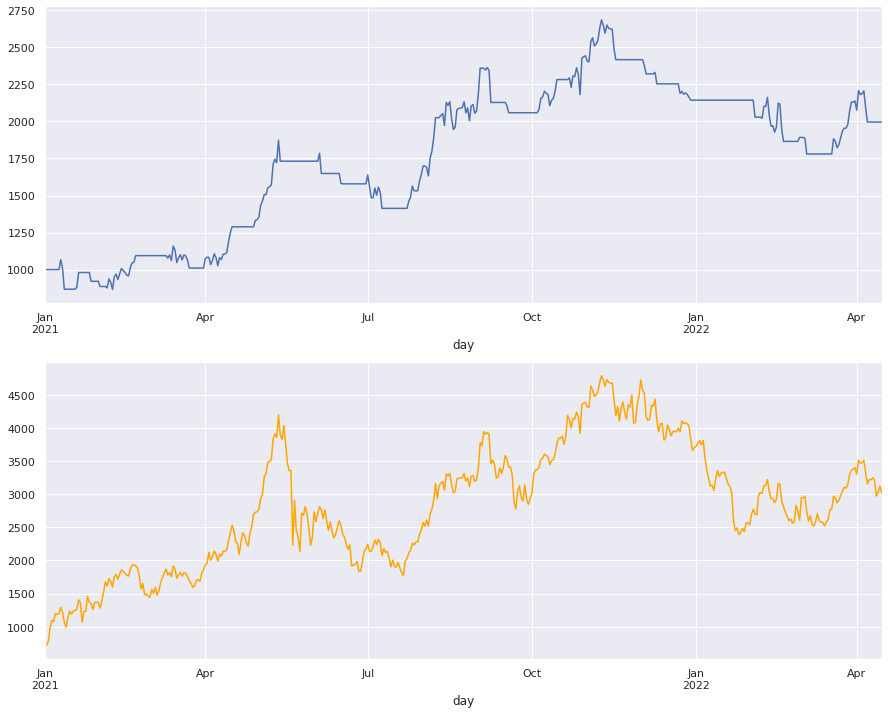

In [21]:
def plot_bar_by_month(df_days):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    custom_palette = {}
    
    last_month = int(df_days.iloc[-1]['day'].month)
    last_year = int(df_days.iloc[-1]['day'].year)
    
    current_month = int(df_days.iloc[0]['day'].month)
    current_year = int(df_days.iloc[0]['day'].year)
    current_year_array = []
    while current_year != last_year or current_month-1 != last_month:
        date_string = str(current_year) + "-" + str(current_month)
        
        monthly_perf = (df_days.loc[date_string]['wallet'].iloc[-1] - df_days.loc[date_string]['wallet'].iloc[0]) / df_days.loc[date_string]['wallet'].iloc[0]
        monthly_row = {
            'date': str(datetime.date(1900, current_month, 1).strftime('%B')),
            'result': round(monthly_perf*100)
        }
        if monthly_row["result"] >= 0:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'g'
        else:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'r'
        current_year_array.append(monthly_row)
        # print(monthly_perf*100) 
        if ((current_month == 12) or (current_month == last_month and current_year == last_year)):
            current_df = pd.DataFrame(current_year_array)
            # print(current_df)
            g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)
            for index, row in current_df.iterrows():
                if row.result >= 0:
                    g.text(row.name,row.result, '+'+str(round(row.result))+'%', color='black', ha="center", va="bottom")
                else:
                    g.text(row.name,row.result, '-'+str(round(row.result))+'%', color='black', ha="center", va="top")
            g.set_title(str(current_year) + ' performance in %')
            g.set(xlabel=current_year, ylabel='performance %')
            
            year_result = (df_days.loc[str(current_year)]['wallet'].iloc[-1] - df_days.loc[str(current_year)]['wallet'].iloc[0]) / df_days.loc[str(current_year)]['wallet'].iloc[0]
            print("----- " + str(current_year) +" Cumulative Performances: " + str(round(year_result*100,2)) + "% -----")
            plt.show()

            current_year_array = []
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

def plot_wallet_vs_asset(df_days):
    fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=1)
    df_days['wallet'].plot(ax=axes[0])
    df_days['price'].plot(ax=axes[1], color='orange')

def show_analys(days, trades):
    df_trades = trades.copy()
    df_days = days.copy()

    df_days['evolution'] = df_days['wallet'].diff()
    df_trades['trade_result'] = df_trades['wallet'].diff()
    df_trades['trade_result_pct'] = df_trades['wallet'].pct_change()

    df_days['wallet_ath'] = df_days['wallet'].cummax()
    df_days['drawdown'] = df_days['wallet_ath'] - df_days['wallet']
    df_days['drawdown_pct'] = df_days['drawdown'] / df_days['wallet_ath']

    initial_wallet = df_days.iloc[0]["wallet"]

    close_trades = df_trades.loc[df_trades['position'] == 'sell']
    good_trades = close_trades.loc[close_trades['trade_result_pct'] > 0]
    total_trades = len(close_trades)
    total_good_trades = len(good_trades)
    avg_profit = close_trades['trade_result_pct'].mean() 
    global_win_rate = total_good_trades / total_trades
    max_days_drawdown = df_days['drawdown_pct'].max()
    final_wallet = df_days.iloc[-1]['wallet']
    buy_and_hold_pct = (df_days.iloc[-1]['price'] - df_days.iloc[0]['price']) / df_days.iloc[0]['price']
    buy_and_hold_wallet = initial_wallet + initial_wallet * buy_and_hold_pct
    vs_hold_pct = (final_wallet - buy_and_hold_wallet)/buy_and_hold_wallet
    vs_usd_pct = (final_wallet - initial_wallet)/initial_wallet
    total_fee = df_trades['fee'].sum()

    best_trade = df_trades['trade_result_pct'].max()
    best_trade_date =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['date'])
    worst_trade = df_trades['trade_result_pct'].min()
    worst_trade_date =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['date'])

    print("Period: [{}] -> [{}]".format(df_days.iloc[0]["day"], df_days.iloc[-1]["day"]))
    print("Initial wallet: {} $".format(round(initial_wallet,2)))

    print("\n--- General Information ---")
    print("Final wallet: {} $".format(round(final_wallet,2)))
    print("Performance vs US dollar: {} %".format(round(vs_usd_pct*100,2)))
    print("Worst Drawdown : -{}%".format(round(max_days_drawdown*100, 2)))
    print("Buy and hold performance: {} %".format(round(buy_and_hold_pct*100,2)))
    print("Performance vs buy and hold: {} %".format(round(vs_hold_pct*100,2)))
    print("Total trades on the period: {}".format(total_trades))
    print("Global Win rate: {} %".format(round(global_win_rate*100, 2)))
    print("Average Profit: {} %".format(round(avg_profit*100, 2)))
    print("Total fee: {} $".format(round(total_fee, 2)))

    print("\nBest trades: +{} % the {}".format(round(best_trade*100, 2), best_trade_date))
    print("Worst trades: {} % the {}".format(round(worst_trade*100, 2), worst_trade_date))

# Fonction pour afficher une analyse complète de la stratégie sur le passé
show_analys(df_days.loc[:], df_trades.loc[:])

print("\n--- Plot wallet evolution vs asset ---")
# Fonction pour afficher une analyse complète de la stratégie sur le passé
plot_wallet_vs_asset(df_days.loc[:])

In [22]:
df_trades[-20:]

,date,position,price,fee,usd,coin,wallet,reason
date,,,,,,,,
2021-12-22 15:00:00,2021-12-22 15:00:00,buy,4007.240000,1.577740,0.000000,0.562067,2252.336695,market
2021-12-22 18:00:00,2021-12-22 18:00:00,sell,3965.261438,1.560119,2227.181818,0.000000,2227.181818,stop loss
2021-12-22 20:00:00,2021-12-22 20:00:00,buy,4004.690000,1.559027,0.000000,0.555754,2225.622791,market
2021-12-23 00:00:00,2021-12-23 00:00:00,sell,3966.691386,1.543153,2202.961753,0.000000,2202.961753,stop loss
2021-12-24 17:00:00,2021-12-24 17:00:00,buy,4098.080000,1.542073,0.000000,0.537183,2201.419679,market
2021-12-28 01:00:00,2021-12-28 01:00:00,sell,3993.334431,1.501606,2143.650514,0.000000,2143.650514,stop loss
2022-02-02 09:00:00,2022-02-02 09:00:00,buy,2775.350000,1.500555,0.000000,0.771849,2142.149959,market
2022-02-02 21:00:00,2022-02-02 21:00:00,sell,2630.946493,1.421485,2029.270832,0.000000,2029.270832,stop loss
2022-02-06 09:00:00,2022-02-06 09:00:00,buy,3018.980000,1.420490,0.000000,0.671700,2027.850343,market


----- 2021 Cumulative Performances: 114.37% -----


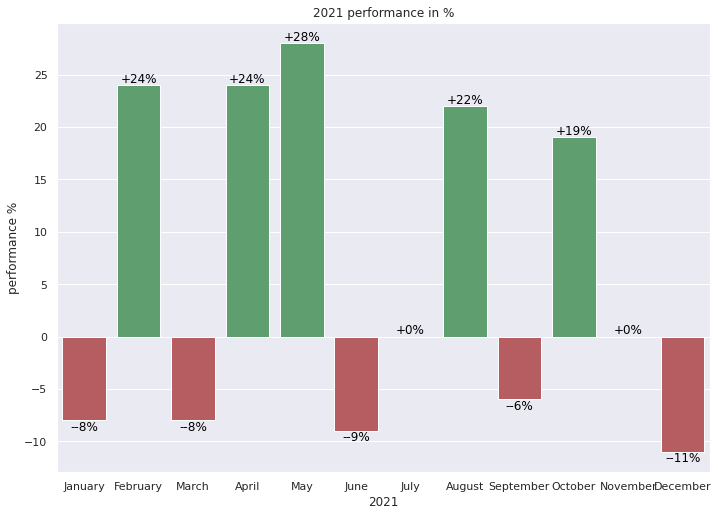

----- 2022 Cumulative Performances: -6.89% -----


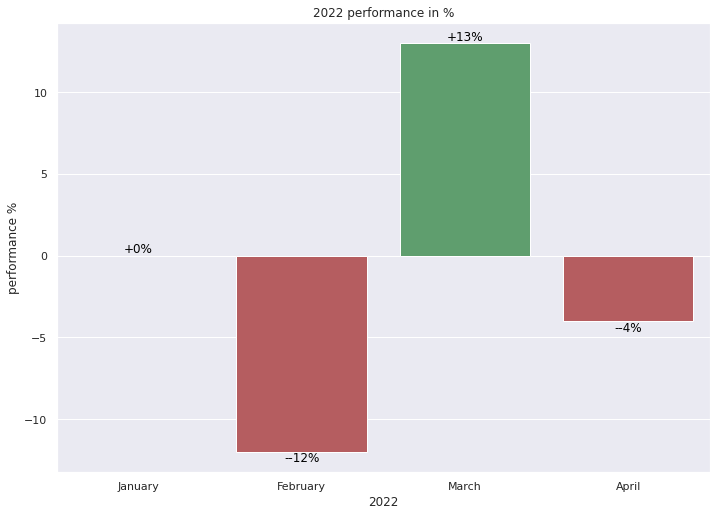

In [23]:
# Fonction pour afficher les gains et les pertes mois par mois
plot_bar_by_month(df_days.loc[:])